In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import sys
from numba import jit
from IPython import display
import warnings
import time

warnings.resetwarnings()

def print_fl(x):
    print(x)
    sys.stdout.flush()

In [2]:
# simulation parameters
delta_r = 1.0
c = 1
q = 7 # number of directions to be considered
num_iter = 10000

omega = 1.0/(0.8)     # Relaxation parameter.
u_inlet = np.array([0.1, 0.0])  # Velocity in lattice units.
rho_inlet = 1.0

# velocity vectors
e = np.zeros((q,2))
e_angles = np.linspace(0,2*np.pi,6,endpoint=False)
e[0,:] = [0,0]                        # zero velocity vector
e[1:,0] = np.cos(e_angles)
e[1:,1] = np.sin(e_angles)

# direction in which outflow occurs, for the application of the outflow bc
outflow_dir = 1

# directional weights
w_e = np.concatenate(([1/2], 1/12*np.ones(6)))

# bounce-back directions
bb_dir = np.concatenate(([0], 1 + ((np.arange(q-1) + (q-1)/2) % 6)))
bb_dir = np.array(bb_dir, dtype=np.int)

/Users/jesse/anaconda/lib/python3.5/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/Users/jesse/anaconda/lib/python3.5/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


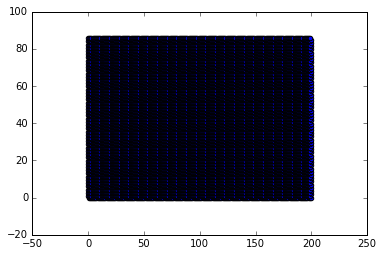

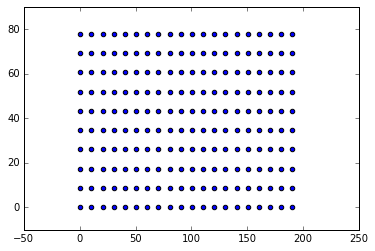

In [3]:
# generate grid (in this case triangular grid on rectangular domain)
N_x = 200
N_y = 100

L_x = N_x * delta_r
L_y = N_y * 1/2*np.sqrt(3)*delta_r

template_x = np.arange(0, L_x, delta_r)
template_y = np.arange(0, L_y, 1/2*np.sqrt(3)*delta_r)

x_points = np.size(template_x)
y_points = np.size(template_y)
n_points = x_points*y_points

template_xi = np.arange(x_points, dtype=np.int)
template_yi = np.arange(y_points, dtype=np.int)

[grid_x, grid_y] = np.meshgrid(template_x, template_y, indexing='ij')
[grid_xi, grid_yi] = np.meshgrid(template_xi, template_yi, indexing='ij')
grid_x[:,::2] += (1/2)*delta_r

neighbours_even_row = np.array([
        [0, 0],   # stationary direction
        [1, 0],   # +x direction
        [1, 1],   # up-right direction
        [0, 1],   # up-left direction
        [-1, 0],  # -x direction
        [0, -1],  # down-left direction
        [1, -1]   # down-right direction
    ])

neighbours_odd_row = np.array([
        [0, 0],   # stationary direction
        [1, 0],   # +x direction
        [0, 1],   # up-right direction
        [-1, 1],  # up-left direction
        [-1, 0],  # -x direction
        [-1, -1], # down-left direction
        [0, -1]   # down-right direction
    ])



link_matrix = np.ones((x_points, y_points, 7, 2), dtype=np.int) * -1

# construct the link matrix by finding neighbours (invalid ones are removed later)
link_matrix[:,::2,:,0] = grid_xi[:,::2, np.newaxis] + neighbours_even_row[:,0]
link_matrix[:,1::2,:,0] = grid_xi[:,1::2, np.newaxis] + neighbours_odd_row[:,0]

link_matrix[:,::2,:,1] = grid_yi[:,::2, np.newaxis] + neighbours_even_row[:,1]
link_matrix[:,1::2,:,1] = grid_yi[:,1::2, np.newaxis] + neighbours_odd_row[:,1]

# reshape lattice into a list
lattice = np.zeros((n_points,2))

lattice[:,0] = grid_x.reshape(n_points)
lattice[:,1] = grid_y.reshape(n_points)

# clean up invalid links
link_matrix_inv_x = (link_matrix[:,:,:,0] >= x_points) | (link_matrix[:,:,:,0] < 0)
link_matrix_inv_y = (link_matrix[:,:,:,1] >= y_points) | (link_matrix[:,:,:,1] < 0)

link_matrix_inv = link_matrix_inv_x | link_matrix_inv_y

link_matrix[link_matrix_inv,:] = -1

# transform link matrix into a flat list that corresponds to the lattice list
link_list = (link_matrix[:,:,:,0] * y_points + link_matrix[:,:,:,1]).reshape((n_points), 7)
link_list[link_list < 0] = -1

# plot grid
plt.scatter(lattice[:,0], lattice[:,1])
plt.show()

# quiver grid
sp = 10
quiver_i = np.array(np.ravel(grid_xi[::sp, ::sp] * y_points + grid_yi[::sp, ::sp]), dtype=np.int)

plt.figure()
plt.scatter(lattice[quiver_i,0], lattice[quiver_i,1])

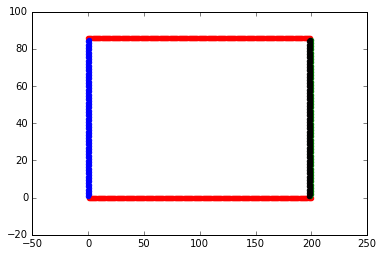

In [4]:
# identify different types of nodes
# bouncing walls identification
lower_wall_i = np.flatnonzero(lattice[:,1] == template_y[0])
upper_wall_i = np.flatnonzero(lattice[:,1] == template_y[-1])

# obstacle identification
obstacle_center = np.array([L_x/4, L_y/2])
obstacle_r = y_points/18

obstacle_i = np.flatnonzero(np.linalg.norm(lattice - obstacle_center, axis=1) < obstacle_r)
bc_noslip_i = np.concatenate((lower_wall_i, upper_wall_i))

# inlet/outlet points identification
bc_inlet_i = np.flatnonzero(lattice[:,0] < (template_x[0] + 3/4*delta_r))
bc_outlet_i = np.flatnonzero(lattice[:,0] > (template_x[-1] - 1/4*delta_r))

# remove conflicting points that have multiple boundary identities
bc_inlet_i = np.setdiff1d(bc_inlet_i, np.intersect1d(bc_inlet_i, bc_noslip_i))
bc_outlet_i = np.setdiff1d(bc_outlet_i, np.intersect1d(bc_outlet_i, bc_noslip_i))

bc_outlet_inflow_i = link_list[bc_outlet_i, bb_dir[outflow_dir]]

boundary_i = np.concatenate((bc_noslip_i, bc_inlet_i, bc_outlet_i))
interior_i = np.setdiff1d(np.arange(n_points), boundary_i)

# plot the grid point identities with colors for inspection purposes
#plt.figure(figsize=(15,15))
plt.scatter(lattice[bc_noslip_i, 0], lattice[bc_noslip_i, 1], color='r')
plt.scatter(lattice[bc_inlet_i, 0], lattice[bc_inlet_i, 1], color='b')
plt.scatter(lattice[bc_outlet_i, 0], lattice[bc_outlet_i, 1], color='g')
plt.scatter(lattice[bc_outlet_inflow_i, 0], lattice[bc_outlet_inflow_i, 1], color='k')
#plt.gca().set_aspect('equal')
    

plt.show()

In [5]:
# debugging code to plot the links between grid points in direction 'direc'
# this code is very slow for large grid sizes

plot_links = False

if plot_links:
    direc = 6
    plt.figure()
    for i in range(n_points):
        if(link_list[i,direc] != -1):
            x1 = lattice[i,0]
            y1 = lattice[i,1]

            x2 = lattice[link_list[i,direc],0]
            y2 = lattice[link_list[i,direc],1]

            plt.arrow(x1, y1, (x2-x1)/2, (y2-y1)/2, head_width=0.2, head_length=0.2)

    plt.scatter(lattice[:,0], lattice[:,1])
    plt.show()

In [6]:
np.size(link_list)

140000

In [7]:
# initialise arrays
f_init = np.zeros((n_points, q))
f_prev = np.zeros((n_points, q))
f_next = np.zeros((n_points, q))

f_eq = np.zeros((n_points, q))

# define equilibrium distribution calculation 
def calc_f_eq(rho, u, e, w_e, c):
    ue = np.dot(u, np.transpose(e))
    uu = np.sum(u*u, axis=1)
    uuee = ue*ue
    
    f_eq = w_e[np.newaxis,:] * rho[:,np.newaxis] * (1 + 4*ue/(c**2) - 2*uu[:,np.newaxis]/(c**2) + 8*uuee/(c**4))
    return f_eq

In [8]:
# set initial conditions: velocity on the inflow boundary + equal density everywhere
initial_u = np.zeros((n_points, 2))
initial_u[bc_inlet_i,:] = u_inlet

initial_rho = np.zeros((n_points))
initial_rho[:] = rho_inlet
initial_rho[bc_noslip_i] = 0.0

f_init[:,:] = calc_f_eq(initial_rho, initial_u, e, w_e, c)
f_prev[:,:] = f_init[:,:]

Finished in 224 s


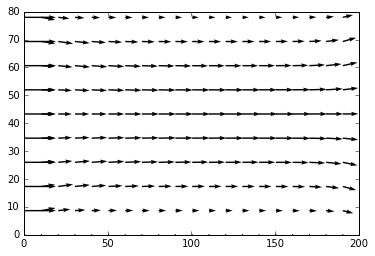

In [9]:
convergence = np.zeros((num_iter))

warnings.simplefilter("error")

visualize = True

if visualize == True:
    fig = plt.figure()
    ax = fig.gca()
    
t = 0

u = np.zeros((n_points, 2))

start_time = time.clock()

# main simulation loop
for t in range(num_iter):
    # clear distribution
    # f_next[:,:] = 0
    
    # right wall boundary condition: outflow condition
    f_prev[bc_outlet_i, :] = f_prev[bc_outlet_inflow_i, :]
    
    # top and bottom wall boundary condition: no slip/bounce-back
    # reshape has to be used to be able to use two index arrays
    f_prev[bc_noslip_i.reshape(-1,1), bb_dir[np.arange(q)]] = f_prev[bc_noslip_i.reshape(-1,1), np.arange(q)]
    
    # calculate macroscopic quantities
    # density: sum distribution over velocity distribution
    rho = np.sum(f_prev, axis=1)
    # velocity: calculate weighted sum of velocities using distributions
    # to prevent division by zero, calculate only for points with finite density
    has_rho = rho > 0
    u[:,:] = 0.0
    u[has_rho,:] = (np.dot(f_prev, e)[has_rho,:])/rho[has_rho,np.newaxis]
    
    # left wall boundary condition: constant velocity inlet
    rho[bc_inlet_i] = initial_rho[bc_inlet_i]
    u[bc_inlet_i,:] = initial_u[bc_inlet_i,:]
    f_prev[bc_inlet_i,:] = f_init[bc_inlet_i,:]
    
    # calculate equilibrium
    f_eq[:,:] = calc_f_eq(rho, u, e, w_e, c)
    
    # collision step, only for interior points
    f_diff = f_prev[interior_i,:] - f_eq[interior_i,:]
    f_prev[interior_i,:] = f_prev[interior_i,:] - omega * (f_diff)
    
    # track the convergence of the algorithm
    # convergence[t] = np.max(np.abs(f_diff))
    
    # streaming step
    for i in range(q):
        # we have to filter out the invalid links 
        valid_links = link_list[:,i] > -1
        f_next[link_list[valid_links,i],i] = f_prev[valid_links,i]
        
    # finish the iteration
    f_prev[:,:] = f_next[:,:]
    
    if visualize == True and t % int(0.05*num_iter) == 0:
        ax.cla()
        #ax.pcolor(lattice[:,0], lattice[:,1], rho)
        #ax.scatter(lattice[:,0], lattice[:,1])
        u[bc_noslip_i,:] = 0.0
        ax.quiver(lattice[quiver_i,0], lattice[quiver_i,1], u[quiver_i,0], u[quiver_i,1])
        display.clear_output(wait=True)
        display.display(fig)
        
    if t % int(0.1*num_iter) == 0:
        print_fl(r"Simulation progress: %.1f%%" % (t/num_iter * 100.0) )
        
end_time = time.clock()

if visualize == True:
    display.clear_output()
    
print_fl("Finished in %.0f s" % (end_time - start_time))

warnings.resetwarnings()

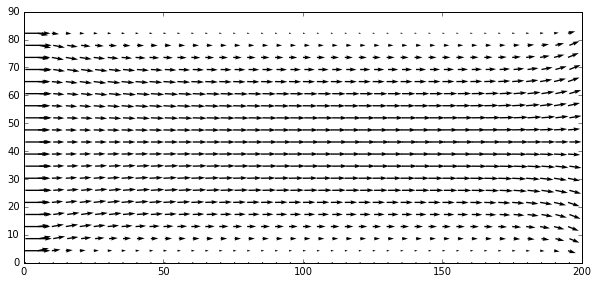

In [10]:
# plot results: flow field

u[bc_noslip_i,:] = 0.0

plt.figure(figsize=(10, 10))
sp = 5

lattice_grid = lattice.reshape(x_points,y_points,2)
u_grid = u.reshape(x_points,y_points,2)

plt.quiver(lattice_grid[::sp,::sp,0], lattice_grid[::sp,::sp,1], u_grid[::sp,::sp,0], u_grid[::sp,::sp,1])
plt.gca().set_aspect('equal')

plt.show()

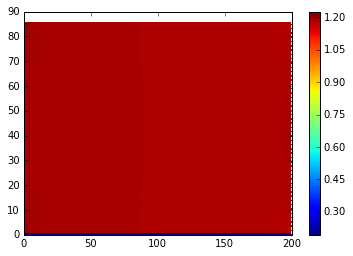

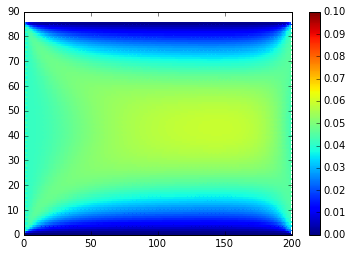

In [11]:
# plot results: density and magnitude of the velocity

plt.pcolor(grid_x, grid_y, rho.reshape(grid_x.shape))
plt.colorbar()

plt.show()

plt.figure()
plt.pcolor(grid_x, grid_y, np.linalg.norm(u_grid, axis=2))
plt.colorbar()
plt.show()

/Users/jesse/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


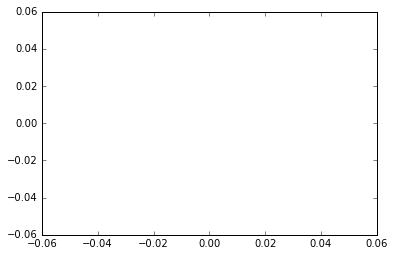

In [12]:
# plot results: logarithm of the convergence

plt.plot(np.log(convergence[1:]))
plt.show()

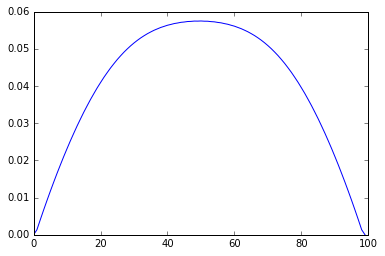

In [13]:
# plot results: x-velocity cross-sectional profile
line = 100

plt.plot(u_grid[line,:,0])

In [14]:
link_list[bc_outlet_i, bb_dir[outflow_dir]]

array([19801, 19802, 19803, 19804, 19805, 19806, 19807, 19808, 19809,
       19810, 19811, 19812, 19813, 19814, 19815, 19816, 19817, 19818,
       19819, 19820, 19821, 19822, 19823, 19824, 19825, 19826, 19827,
       19828, 19829, 19830, 19831, 19832, 19833, 19834, 19835, 19836,
       19837, 19838, 19839, 19840, 19841, 19842, 19843, 19844, 19845,
       19846, 19847, 19848, 19849, 19850, 19851, 19852, 19853, 19854,
       19855, 19856, 19857, 19858, 19859, 19860, 19861, 19862, 19863,
       19864, 19865, 19866, 19867, 19868, 19869, 19870, 19871, 19872,
       19873, 19874, 19875, 19876, 19877, 19878, 19879, 19880, 19881,
       19882, 19883, 19884, 19885, 19886, 19887, 19888, 19889, 19890,
       19891, 19892, 19893, 19894, 19895, 19896, 19897, 19898])

In [15]:
bc_outlet_i

array([19901, 19902, 19903, 19904, 19905, 19906, 19907, 19908, 19909,
       19910, 19911, 19912, 19913, 19914, 19915, 19916, 19917, 19918,
       19919, 19920, 19921, 19922, 19923, 19924, 19925, 19926, 19927,
       19928, 19929, 19930, 19931, 19932, 19933, 19934, 19935, 19936,
       19937, 19938, 19939, 19940, 19941, 19942, 19943, 19944, 19945,
       19946, 19947, 19948, 19949, 19950, 19951, 19952, 19953, 19954,
       19955, 19956, 19957, 19958, 19959, 19960, 19961, 19962, 19963,
       19964, 19965, 19966, 19967, 19968, 19969, 19970, 19971, 19972,
       19973, 19974, 19975, 19976, 19977, 19978, 19979, 19980, 19981,
       19982, 19983, 19984, 19985, 19986, 19987, 19988, 19989, 19990,
       19991, 19992, 19993, 19994, 19995, 19996, 19997, 19998])